# MLLAB project Recommand System -- chengcheng Guo


### load data

In [1]:
import numpy as np
# load data
data = np.load('dataset.npy')

In [2]:
# userID, ItemID , Rating
data

array([[   2,  566,    1],
       [   2,  750,    2],
       [   2,  391,    1],
       ...,
       [5498,  516,    2],
       [5498,  650,    3],
       [5498,  651,    2]])

In [5]:
data.dtype

dtype('int32')

In [31]:
shape_d = data.shape
print("data shape is : ",shape_d)

data shape is :  (380311, 3)


In [32]:
# Getting the number of  users ,items ,rates
import pandas as pd
df = pd.DataFrame(data)

users, items, ratings = df.nunique()
print("we have %d users"%users)
print("we have %d items"%items)
print("we have %d ratings"%ratings)

we have 1643 users
we have 1194 items
we have 5 ratings


In [5]:
print("biggest user id: ", np.max(data[:,0]))
print("biggest item id: ", np.max(data[:,1]))

biggest user id:  5498
biggest item id:  2079


In [33]:
mue = np.mean(data[:,2])
mue

0.3963046033377946

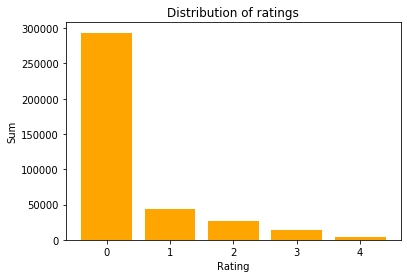

In [7]:
import matplotlib.pyplot as plt
# Plot histogram
unique, counts = np.unique(data[:,2], return_counts=True)
plt.bar(unique, counts, align='center', color = "orange")
plt.xticks(unique)
plt.xlabel('Rating')
plt.ylabel('Sum')
plt.title('Distribution of ratings')
#plt.savefig('./rate_distributuin.png',dpi = 500, bbox_inches = 'tight')
plt.show()

In [9]:
# TODO: Split data into train and test data
from sklearn.model_selection import train_test_split
# seperate rate = 0 and no rate
data[:,2]=data[:,2]+1
# we split  into train and  test after +1, so we do not need to -1 after predict to calculate error 
X_train, X_test= train_test_split(data, test_size=0.2)

In [10]:
# reconstruct dense matrix to Sparse matrix 
from scipy.sparse import csr_matrix

def sparse_matrix(data):
    return csr_matrix((data[:,2], (data[:,0].astype(int), data[:,1].astype(int))))

In [39]:
Xtrain_sparse = sparse_matrix(X_train)
Xtest_sparse  = sparse_matrix(X_test)

In [41]:
Xtest_sparse.shape

(5499, 2080)

### Pearson correlation

Here we want to use the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) as a measure for correlation between two items.



\begin{eqnarray}
\operatorname{sim}(i, j) & = & \frac{\sum_{u \in \operatorname{InJ}}\left(r_{u i}-\mu_{i}\right)\left(r_{u j}-\mu_{j}\right)}{\sqrt{\sum_{u \in \operatorname{InJ}}\left(r_{u i}-\mu_{i}\right)^{2}} \sqrt{\sum_{u \in I \cap J}\left(r_{u j}-\mu_{j}\right)^{2}}}
\end{eqnarray}

In [12]:
from tqdm.notebook import tqdm

In [13]:
# 
mean_train = csr_matrix.sum(Xtrain_sparse)/csr_matrix.count_nonzero(Xtrain_sparse)
mean_test = csr_matrix.sum(Xtest_sparse)/csr_matrix.count_nonzero(Xtest_sparse)

user_num, item_num = Xtrain_sparse.shape

# items
count_nonzeros = [csr_matrix.count_nonzero(Xtrain_sparse[:,i]) for i in range(item_num)]
sum_item = csr_matrix.sum(Xtrain_sparse, axis = 0)
mue_item = [0 if count_nonzeros[i] == 0 else sum_item[0,i]/count_nonzeros[i] for i in range(item_num)]
mue_item = np.array(mue_item)

# users
count_nonzeros = [csr_matrix.count_nonzero(Xtrain_sparse[i,:]) for i in range(user_num)]
sum_users = csr_matrix.sum(Xtrain_sparse, axis = 1)
mue_user = [0 if count_nonzeros[i] == 0 else sum_users[i]/count_nonzeros[i] for i in range(user_num)]
mue_user = np.array(mue_user)

In [16]:
def Pearson_corr(matrix, mue_item):
    
    Corr = np.zeros((item_num,item_num), dtype=float)
    for i in tqdm(range(item_num)):
        u = np.squeeze(matrix[:,i].toarray())
        mue_u=mue_item[i]
        u = [(u[n] - mue_item[i]) if u[n] > 0 else 0 for n in range(user_num)]
        u_d = np.sqrt(np.dot(u,u))
        for j in range(i,item_num):
            u2 = np.squeeze(matrix[:,i].toarray())
            mue_u2=mue_item[i]
            u2 = [(u2[n] - mue_item[i]) if u2[n] > 0 else 0 for n in range(user_num)]
            u2_d = np.sqrt(np.dot(u2,u2))
            sim_numerator = np.dot(u,u2)            
            sim_denominator = u_d*u2_d
            if sim_denominator!=0:
                sim=sim_numerator/sim_denominator
            else:
                sim=-float('inf')
            Corr[i,j]=sim
            Corr[j,i]=sim
                        
    return Corr

In [17]:
%%time
sim_train = Pearson_corr(Xtrain_sparse,mue_item)
np.savetxt('sim_train_2.csv', sim_train, delimiter = ',')


Wall time: 6h 12min 46s


In [14]:
# read corr dataset because it take too long to calculate
Corr_train = np.genfromtxt("sim_train_2.csv", delimiter=",", dtype=np.float)

\begin{array}{c}
\quad b_{u}=\mu_{u}-\mu   \\
\quad b_{i}=\mu_{i}-\mu  \\
\end{array}

In [ ]:
#bias
b_item=np.subtract(mue_item,mue)
b_user=np.subtract(mue_user,mue)

\begin{array}{c}
\hat{r}_{u i}=\mu+b_{u}+b_{i} \\
\end{array}

In [30]:
#  A first-order approximation of the bias involved in rating rui
def Baseline_method(matrix, mean, bu, bi):
    Pui = np.zeros(len(matrix[:,0]))
    for i in range(len(matrix[:,0])):
        predvalue = mean + bu[matrix[i,0].astype(int)] + bi[matrix[i,1].astype(int)]
        Pui[i] = predvalue
    Pui = np.clip(Pui,1,5)
    return Pui

In [66]:
from sklearn.metrics import mean_squared_error
bt_pred = Baseline_method(X_train, mean_train, b_user, b_item)
mse_train = mean_squared_error(X_train[:,2], bt_pred)
print(f"MSE train：%s"%mse_train)
print(f"RMSE train：%s"%(np.sqrt(mse_train)))

MSE train：4.350566103537018
RMSE train：2.085801069981751


In [67]:
bte_pred = Baseline_method(X_test, mean_train, b_user, b_item)
mse_test = mean_squared_error(X_test[:,2], b_pred)
print(f"MSE test：%s"%mse_test)
print(f"RMSE test：%s"%(np.sqrt(mse_test)))

MSE test：4.351767225376472
RMSE test：2.0860889782980188


### KNN

\begin{array}{c}
\hat{r}_{i u}=\mu_{i}+\frac{\sum_{j \in P} \operatorname{sim}(i, j) \cdot s_{j u}}{\sum_{j \in P}|\operatorname{sim}(i, j)|}
\end{array}

In [21]:
# KNN method to predict rating 
def KNN(k, matrix, spa_matrix, mue_item, Corr, pred):
    for i in range(len(matrix)):
        Interaction = matrix[i,:]
        UserID=Interaction[0].astype(int)
        ItemID=Interaction[1].astype(int)
        # Get the row of ratings from the selected userID in sparse matrix
        User_row = np.squeeze(spa_matrix[UserID,:].toarray())
        # indexs of non zero ratings
        Rated_items = np.array(np.squeeze(np.nonzero(User_row)),ndmin=1) 
        # similarities between current Item and rated Items
        sim_all = Corr[ItemID,Rated_items] 
        # sorted item ID in descending order
        sorted_items = Rated_items[np.argsort(sim_all)[::-1]] 
        # corresponding sorted similarities in descending order
        sorted_sims = sim_all[np.argsort(sim_all)[::-1]] 
        k_items = sorted_items[0:min(k,len(sorted_items)-1)]
        k_sims = sorted_sims[0:min(k,len(sorted_items)-1)]
        k_sims = np.clip(k_sims,0,1)
        k_ratings = User_row[k_items]
        k_mean = mue_item[k_items]
        # r(hat)(iu) = mue[i] + sim/|sim|
        weighted_sum = np.dot(k_sims, np.subtract(k_ratings,k_mean))
        if np.sum(np.abs(k_sims)) > 0:
            pred[i] = mue_item[ItemID] + weighted_sum/np.sum(np.abs(k_sims))
    pred = np.clip(pred,1,5)
    return pred

\begin{array}{c}
     M S E = \frac{1}{n} \sum_{i = 1}^{n}\left(r_{u i}-\hat{r}_{u i}\right)^{2}
\end{array} 

\begin{array}{c}
    R M S E=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(r_{u i}-\hat{r}_{u i}\right)^{2}}
\end{array}

In [32]:
def rmse(Y, Y_hat):
    # TODO: calculate RMSE
    return np.sqrt(np.mean((Y-Y_hat)**2))

### KNN train error {neighbor, RMSE, MSE}

In [91]:
# knn of different k implememnt
res = np.empty(shape = (0,3))
for k in tqdm(range(1,35)):
    Knn_pred = KNN(k, X_train, Xtrain_sparse, mue_item, Corr_train, bt_pred)        
    err = rmse(X_train[:,2], Knn_pred)    
    M_err = mean_squared_error(X_train[:,2], Knn_pred)
    #print(k, err,M_err)
    res =  np.r_[res,[[k, err, M_err]]]
np.savetxt('KNN_ERROR_train1.csv', res, delimiter = ',')

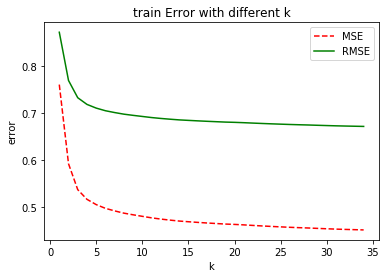

In [24]:
# read error dataset because it take too long to calculate
err_train = np.genfromtxt("KNN_ERROR_train1.csv", delimiter=",", dtype=np.float)
l1=plt.plot(err_train[:,0],err_train[:,2],'r--',label='MSE')
l2=plt.plot(err_train[:,0],err_train[:,1],'g',label='RMSE')

plt.title('train Error with different k')
plt.xlabel('k')
plt.ylabel('error')
plt.legend()
#plt.savefig('./trainKNNerror.png',dpi = 500, bbox_inches = 'tight')


### KNN TEST error {neighbor, RMSE, MSE}

In [94]:
# knn of different k implememnt
res = np.empty(shape = (0,3))
for k in tqdm(range(1,36)):
    Knn_pred = KNN(k, X_test, Xtrain_sparse, mue_item, Corr_train, bte_pred)        
    err = rmse(X_test[:,2], Knn_pred)    
    M_err = mean_squared_error(X_test[:,2], Knn_pred)
    #res.append(k, err,M_err)
    res = np.r_[res,[[k, err, M_err]]]
np.savetxt('KNN_ERROR_test1.csv', res, delimiter = ',')

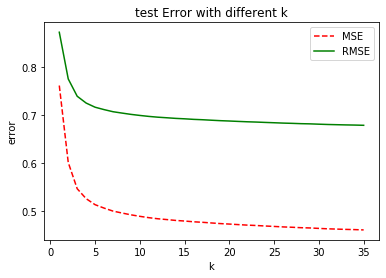

In [25]:
# read data
err_test = np.genfromtxt("KNN_ERROR_test1.csv", delimiter=",", dtype=np.float)
#plot
l1=plt.plot(err_test[:,0],err_test[:,2],'r--',label='MSE')
l2=plt.plot(err_test[:,0],err_test[:,1],'g',label='RMSE')

plt.title('test Error with different k')
plt.xlabel('k')
plt.ylabel('error')
plt.legend()
#plt.savefig('./testKNNerror.png',dpi = 500, bbox_inches = 'tight')
